In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np

In [ ]:
half1 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/half1.h5ad')
# half2 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/half2.h5ad')

In [ ]:
sc.pp.filter_cells(half1, min_genes=100)
sc.pp.filter_genes(half1, min_cells=3)

In [ ]:
sc.pp.normalize_total(half1)
sc.pp.log1p(half1)

In [ ]:
half1

In [ ]:
half1.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/half1.h5ad')

## concat adata

In [2]:
# microglia = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/microglia.h5ad')
# inhibitory = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/inhibitory.h5ad')
# cux2_1 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/cux2+.h5ad')
# cux2_2 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/cux2-.h5ad')
# astrocytes = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/astrocytes.h5ad')
# oligo = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/oligodendroglia.h5ad')
# vascular = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/vascular.niche.h5ad')


In [3]:
# half1 = ad.concat([microglia, inhibitory, cux2_1, cux2_2])
# clinical = pd.read_csv('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/ROSMAP_clinical.csv')
# half1.obs = pd.merge(half1.obs, clinical, on = 'individualID', how = 'left')
# half1.obs['class'] = half1.obs['class'].astype(str)
# half1.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/half1.h5ad')

In [4]:
# half2 = ad.concat([astrocytes, oligo, vascular])
# clinical = pd.read_csv('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/ROSMAP_clinical.csv')
# half2.obs = pd.merge(half2.obs, clinical, on = 'individualID', how = 'left')
# half2.obs['class'] = half2.obs['class'].astype(str)
# half2.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/half2.h5ad')

In [2]:
half1 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/half1.h5ad')
half2 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/half2.h5ad')

/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
all = ad.concat([half1, half2])
all

/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 1649672 × 18745
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv'
    obsm: 'X_umap'

In [4]:
all.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all.h5ad')

In [3]:
print(microglia.shape)
print(inhibitory.shape)
print(cux2_1.shape)
print(cux2_2.shape)
print(astrocytes.shape)
print(oligo.shape)
print(vascular.shape)


(86612, 19183)
(257929, 20102)
(378546, 20326)
(268854, 20326)
(228925, 19874)
(409572, 19925)
(19234, 18745)


## process

In [2]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all.h5ad')

/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 1649672 × 18745
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv'
    obsm: 'X_umap'>

In [4]:
adata

AnnData object with n_obs × n_vars = 1649672 × 18745
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv'
    obsm: 'X_umap'

In [ ]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="batch")

In [ ]:
adata.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_hvg.h5ad')

## processed data (above was raw)

In [2]:
microglia = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/processed_h5ad/microglia.h5ad')
# inhibitory = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/processed_h5ad/inhibitory.h5ad')
# cux2_1 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/processed_h5ad/cux2+.h5ad')
# cux2_2 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/processed_h5ad/cux2-.h5ad')
# astrocytes = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/processed_h5ad/astrocytes.h5ad')
# oligo = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/processed_h5ad/oligodendroglia.h5ad')
# vascular = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/processed_h5ad/vascular.niche.h5ad')


/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [ ]:
# all = ad.concat([microglia, inhibitory, cux2_1, cux2_2, astrocytes, oligo, vascular])

In [ ]:
# all.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/processed_h5ad/all.h5ad')

In [4]:
microglia

AnnData object with n_obs × n_vars = 86612 × 4000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state'
    var: '_index', 'features'
    uns: 'neighbors', 'state_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

In [7]:
microglia.obs[microglia.obs.batch == '190403-B4-A']

,nCount_RNA,nFeature_RNA,nCount_SCT,nFeature_SCT,batch,individualID,DoubletFinder.score,subset,class,state
190403-B4-A_AGGGCCTAGGCAGCTA-1,3903.0,2046,3514.0,2046,190403-B4-A,R4119160,0.00,Microglia,1,Mic.1
190403-B4-A_TTCCAATTCACACCGG-1,3758.0,2136,3512.0,2136,190403-B4-A,R4641987,0.00,Microglia,1,Mic.13
190403-B4-A_TACTGCCTCAAGCCCG-1,3668.0,1861,3446.0,1861,190403-B4-A,R5693901,0.02,Microglia,1,Mic.13
190403-B4-A_ATACCTTCATCCGAAT-1,3396.0,2017,3326.0,2017,190403-B4-A,R9116123,0.00,Microglia,1,Mic.7
190403-B4-A_CATGGTAAGCTCATAC-1,3268.0,1959,3239.0,1959,190403-B4-A,R2670295,0.00,Microglia,1,Mic.12
...,...,...,...,...,...,...,...,...,...,...
190403-B4-A_ATTCGTTGTATGTCCA-1,462.0,420,1982.0,823,190403-B4-A,R7047807,0.67,Microglia,1,Mic.7
190403-B4-A_CTGTCGTGTTCCACAA-1,432.0,378,1961.0,804,190403-B4-A,R7047807,0.18,Microglia,1,Mic.2
190403-B4-A_ATCGTGAAGAGCAACC-1,458.0,383,1990.0,773,190403-B4-A,R9116123,0.18,Microglia,1,Mic.7
190403-B4-A_AACGTCATCCGTCACT-1,416.0,348,1970.0,768,190403-B4-A,R4119160,0.53,Microglia,1,Mic.2


In [8]:
microglia.obs[microglia.obs.batch == '190403-B4-B']

,nCount_RNA,nFeature_RNA,nCount_SCT,nFeature_SCT,batch,individualID,DoubletFinder.score,subset,class,state
190403-B4-B_AGACTCATCTCGCGTT-1,4569.0,2166,3566.0,2162,190403-B4-B,R4119160,0.01,Microglia,1,Mic.16
190403-B4-B_CAGATTGCATCGAAGG-1,4108.0,2563,3694.0,2562,190403-B4-B,R4119160,0.01,Microglia,1,Mic.1
190403-B4-B_ATGGGTTCAACGAGGT-1,3955.0,2148,3540.0,2148,190403-B4-B,R4641987,0.01,Microglia,1,Mic.2
190403-B4-B_CATCCACTCTACTCAT-1,3966.0,2022,3520.0,2022,190403-B4-B,R4119160,0.01,Microglia,1,Mic.6
190403-B4-B_TTCGCTGAGGGTTAAT-1,3749.0,2099,3497.0,2099,190403-B4-B,R6759986,0.10,Microglia,1,Mic.10
...,...,...,...,...,...,...,...,...,...,...
190403-B4-B_GATGGAGAGGTTATAG-1,438.0,387,1952.0,813,190403-B4-B,R2670295,0.43,Microglia,1,Mic.2
190403-B4-B_TAAGCGTGTAGGTTTC-1,424.0,351,1987.0,767,190403-B4-B,R5693901,0.36,Microglia,1,Mic.3
190403-B4-B_CTAACTTCAACTACGT-1,419.0,368,1943.0,797,190403-B4-B,R4641987,0.44,Microglia,1,Mic.2
190403-B4-B_TGTTCTAGTACGTGTT-1,420.0,347,1969.0,749,190403-B4-B,R4119160,0.21,Microglia,1,Mic.6


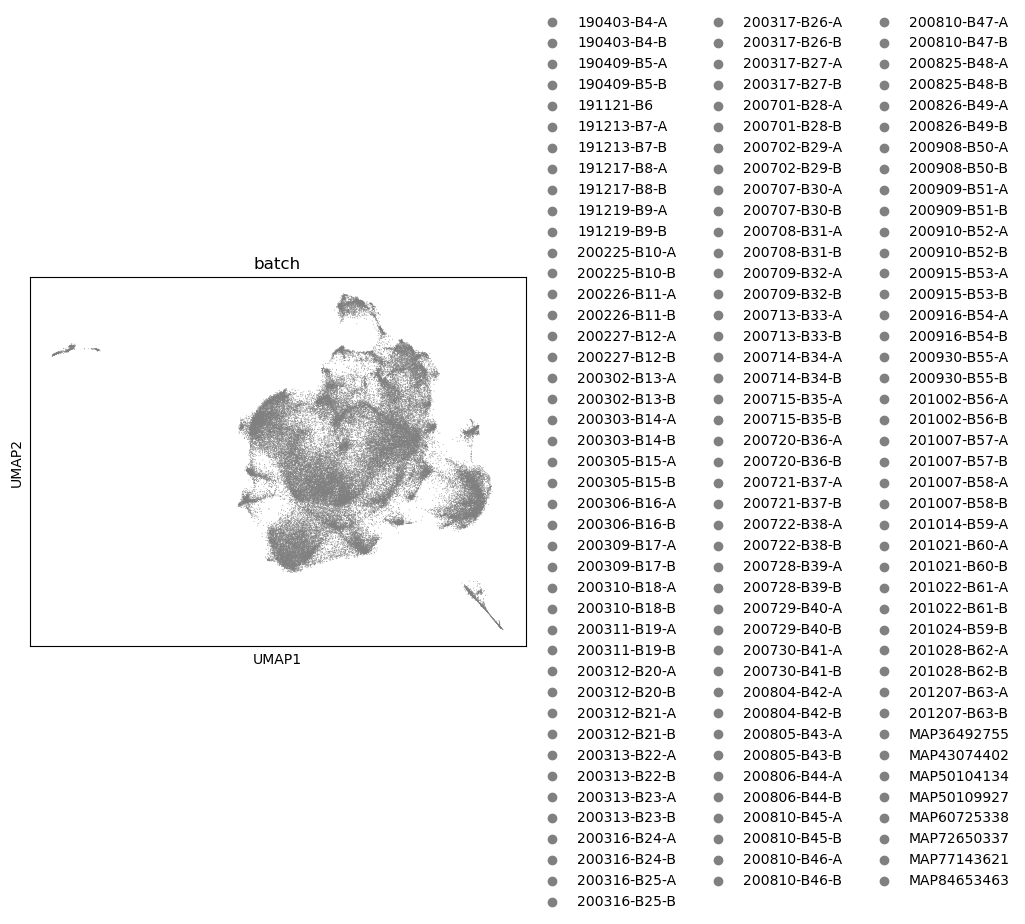

In [5]:
sc.pl.umap(microglia, color = 'batch')